## 9.6 Estimation and order selection
In this section we'll continue to read through the book, but we will also look at the the library [`statsforest`](https://nixtlaverse.nixtla.io/statsforecast/index.html) which claims it can be used in production environments. It seems also to be a component of Nixtla who has other forecasting libraries such as TimeGPT and NeuralForecast, which are worth investigating in the future.

### Maximum likelihood estimation
Once the model order has been identified (i.e. the values of $p$, $d$ and $q$), we need to estimate the parameters $c$, $\phi_1,\ldots,\phi_p$, $\theta_1,\ldots,\theta_q$. One of the techniques that can be used is *maximum likelihood estimation* (MLE). This technique finds the values of the parameters which maximise the probability of obtaining the data that we have observed. For ARIMA models, MLE is similar to the *least squares* estimates that would be obtained by minimising
$$
\sum_{t=1}^T\epsilon_t^2.
$$

### Information Criteria
Akaike's Information Criterion (AIC), which was useful in selecting predictors for regression, is also useful for determining the order of an ARIMA model. It can be written as
$$
\text{AIC} = -2\log(L) + 2(p + q+ k+1),
$$
where $L$ is the likelihood of the data, $k=1$ if $c\ne 0$ and $k=0$ if $c=0$. Note the last term in parenthesis is the number of parameters in the model (including $\sigma^2$, the variance of the residuals).

For ARIMA models, the corrected AIC can be written as
$$
\text{AIC}_c = \text{AIC} + \frac{2(p+q+k+q)(p+q+k+2)}{T-p-q-k-2},
$$
and the Bayesian Information Criterion can be written as
$$
\text{BIC} = \text{AIC} + [\log(T)-2](p+q+k+1)
$$
Good models are obtained by minimising the AIC, AICd or BIC.

It is important to note that these information criteria tend not to be good guides to selecting the appropriate order of differencing ($d$) of a model, but only $p$ and $q$. This is because the differencing changes the data on which the likelihood is computed, making the AIC values between models with different orders of differencing not comparable.



Let's look at the `statsforecast` library and its implementation of `AutoARIMA` which automatically fit an ARIMA model on data. This function exists in R, but not in statsmodels.

### How to find the order of differencing (d) in ARIMA model
From the Nixtla reference page on ARIMA: https://nixtlaverse.nixtla.io/statsforecast/docs/models/arima.html

- As stated earlier, the purpose of differencing is to make the time series stationary. But we should be careful to not over-difference the series. An over differenced series may still be stationary, which in turn will affect the model parameters.

- So we should determine the right order of differencing. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

- If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

- If we can’t really decide between two orders of differencing, then we go with the order that gives the least standard deviation in the differenced series.

Now, we will explain these concepts with the help of an example as follows:

- First, check if the series is stationary using the **Augmented Dickey Fuller test** (ADF Test), from the `statsmodels` package. The reason being is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, $d=0$.

- The null hypothesis ($H_0$) of the ADF test is that the time series is non-stationary. So, if the $p$-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.

- So, in our case, if $p$-value > 0.05 we go ahead with finding the order of differencing.

In [1]:
import sys
sys.path.append('..')
from utils import *

In [2]:
df = pd.read_csv('../data/external/Esperanza_vida.csv', usecols=[1, 2])
df.head()

,year,value
0,1960-01-01,69.123902
1,1961-01-01,69.760244
2,1962-01-01,69.149756
3,1963-01-01,69.248049
4,1964-01-01,70.311707


IMPORTANT! The input to `StatsForecast` is always a DataFrame in long format with three columns: `unique_id`, `ds` and `y`:
- The `unique_id` (string, int or category) represents an identifier for the series.
- The `ds` (datestamp) column should be of a format expected by Pandas, ideally `YYYY-MM-DD` for a date or `YYYY-MM-DD HH:MM:SS` for a timestamp.
- The `y` (numeric) represents the measurement we wish to forecast.

In [3]:
df['unique_id'] = 1
df.columns = ['ds', 'y', 'unique_id']
df.head()

,ds,y,unique_id
0,1960-01-01,69.123902,1
1,1961-01-01,69.760244,1
2,1962-01-01,69.149756,1
3,1963-01-01,69.248049,1
4,1964-01-01,70.311707,1


In [4]:
# Convert `ds` from `object` to datetime
df['ds'] = pd.to_datetime(df['ds'])

In [5]:
from statsforecast import StatsForecast

#### Explore the data with the plot method

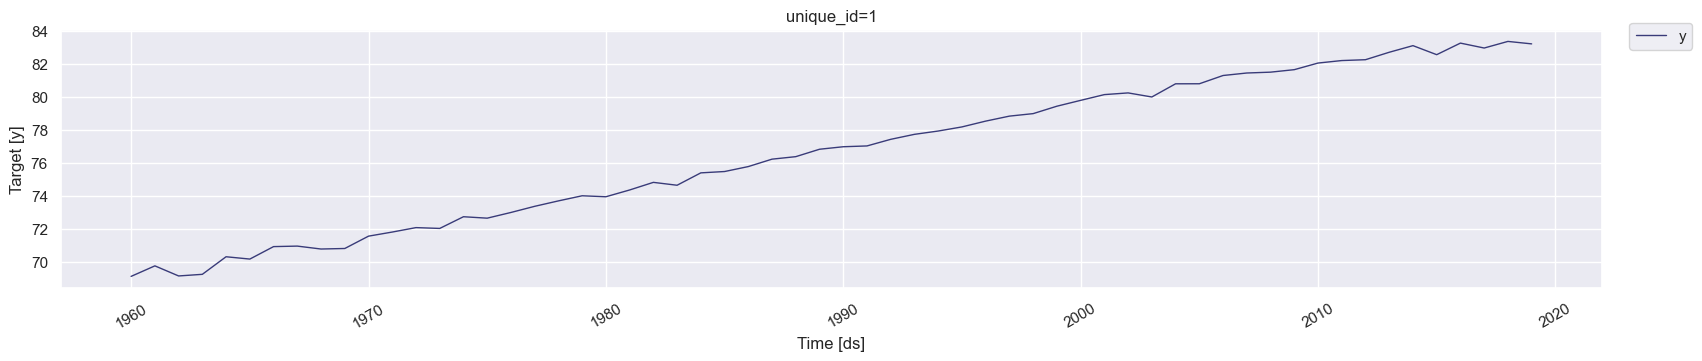

In [6]:
StatsForecast.plot(df)

count    60.000000
mean     76.632439
std       4.495279
min      69.123902
25%      72.712622
50%      76.895122
75%      80.781098
max      83.346341
Name: y, dtype: float64

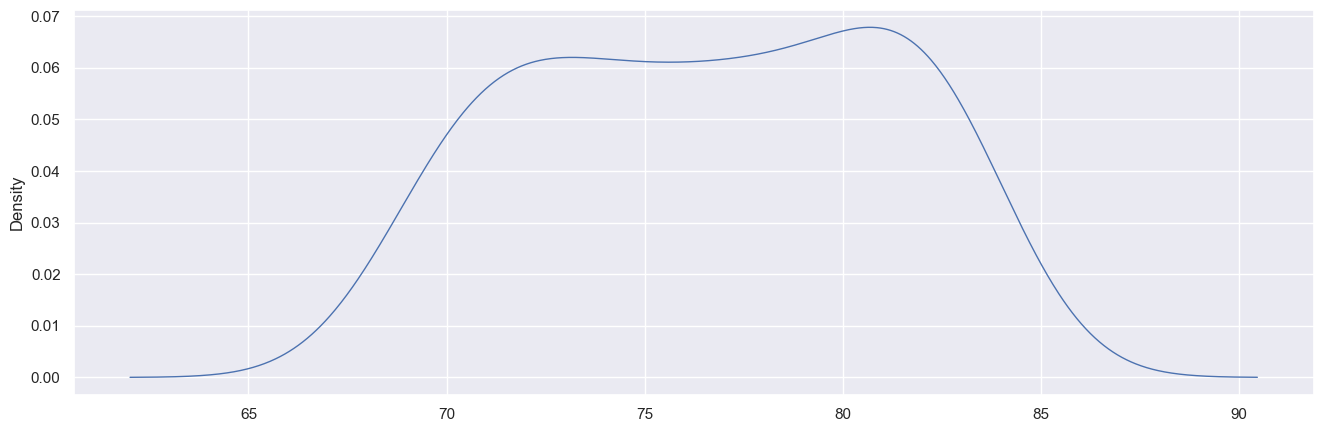

In [7]:
df['y'].plot(kind='kde', figsize=(16, 5))
df['y'].describe()

#### Seasonal Decomposed
For details, see chapter 3 in FPP3 ([Time Series Decomposition](https://otexts.com/fpp3/decomposition.html)).

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

- **Level**: This is the primary value that averages over time.
- **Trend**: The trend is the value that causes increasing or decreasing patterns in a time series.
- **Seasonality**: This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
- **Residual/Noise**: These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

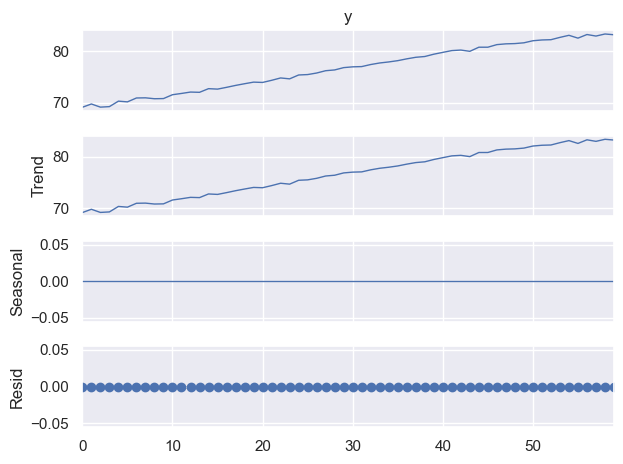

In [11]:
decomposed = seasonal_decompose(df['y'], model='add', period=1)
decomposed.plot()
plt.show();

#### The Augmented Dickey-Fuller Test
An Augmented Dickey-Fuller (ADF) test is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed in the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is not stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as stationary trend. The values of the ADF test statistic are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis. (See FPP3 section 9.1 for the KPSS test, where the null hypothesis is stationarity).

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [14]:
Augmented_Dickey_Fuller_Test_func(df['y'], 'Life expectancy')

Dickey-Fuller test results for columns: Life expectancy
Test Statistic                 -1.578590
p-value                         0.494339
No Lags Used                    2.000000
Number of observations used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
The data is not stationary


We can see in the result that we obtained the non-stationary series, because the p-value is greater than 5%.

One of the objectives of applying the ADF test is to know if our series is stationary, knowing the result of the ADF test, then we can determine the next step. For our case, it can be seen from the previous result that the time series is not stationary, so we will proceed to the next step, which is to differentiate our time series.

We are going to create a copy of our data, with the objective of investigating to find the stationarity in our time series.

Once we have made the copy of the time series, we are going to differentiate the time series, and then we will use the augmented Dickey Fuller test to investigate if our time series is stationary.

In [15]:
df1 = df.copy()
df1['y_diff'] = df['y'].diff()
df1.dropna(inplace=True)
df1.head()

,ds,y,unique_id,y_diff
1,1961-01-01,69.760244,1,0.636341
2,1962-01-01,69.149756,1,-0.610488
3,1963-01-01,69.248049,1,0.098293
4,1964-01-01,70.311707,1,1.063659
5,1965-01-01,70.171707,1,-0.140000


In [16]:
Augmented_Dickey_Fuller_Test_func(df1['y_diff'], 'Life expectancy')

Dickey-Fuller test results for columns: Life expectancy
Test Statistic                -8.510100e+00
p-value                        1.173776e-13
No Lags Used                   1.000000e+00
Number of observations used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


We can observe in the previous result that now if our time series is stationary, the p-value is less than 5%.

Now our time series is stationary, that is, we have only differentiated 1 time, therefore, the order of our parameter $d=1$.

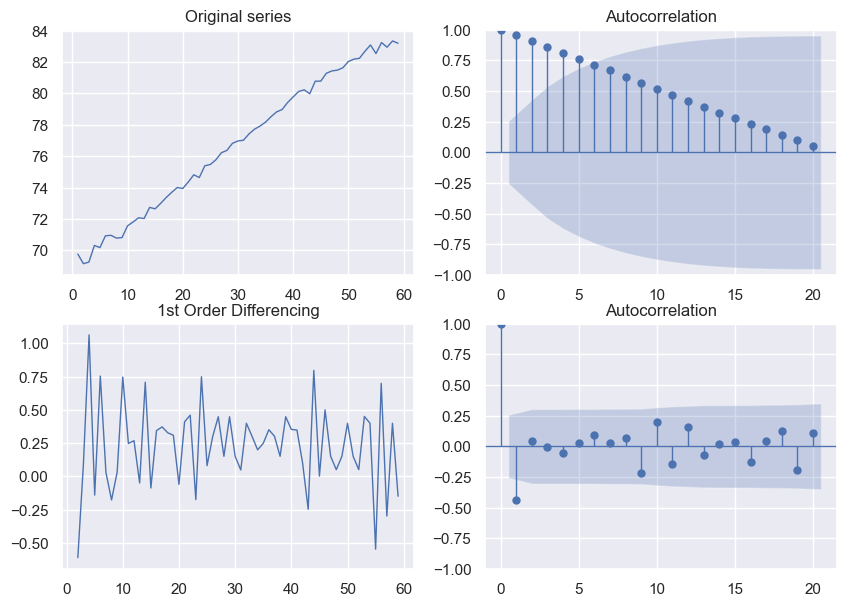

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes[0, 0].plot(df1['y']); axes[0, 0].set(title='Original series')
plot_acf(df1['y'], ax=axes[0, 1], lags=20)

axes[1, 0].plot(df1["y"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df1["y"].diff().dropna(), ax=axes[1, 1],lags=20)
plt.show();


For the above data, we can see that the time series reaches stationarity with one orders of differencing.

To estimate the values of $p$ and $q$, we use partial autocorrelations (PACF) as described in section 9.5.

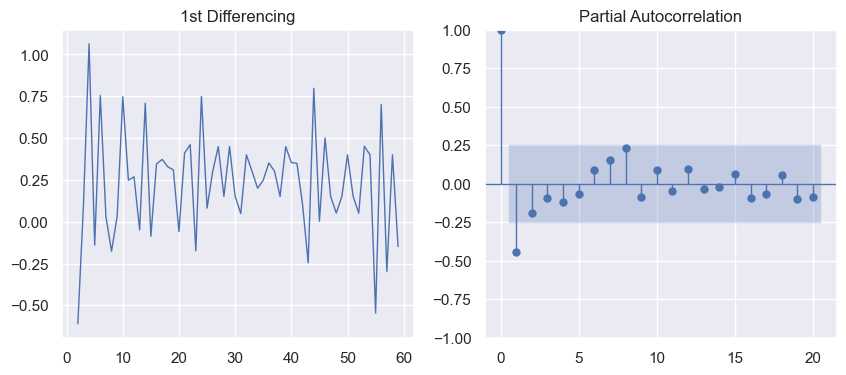

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(df1["y"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df1["y"].diff().dropna(), ax=axes[1],lags=20);

In this instance it was decided to set $p = 1$ for the autoregressive model, $q=1$ for the moving average model and for the stationarity of the model the order of differencing $d=1$. So the model to be tested is the ARIMA(1, 1, 1) model.

In [ ]:
from statsforecast.models import ARIMA

In [24]:
arima = ARIMA(order=(1, 1, 1), season_length=1)
arima = arima.fit(y=df['y'].values)

Making the predictions:

In [25]:
y_hat_dict = arima.predict(h=6,)
y_hat_dict

{'mean': array([83.20690258, 83.20350815, 83.20474158, 83.20429339, 83.20445624,
        83.20439707])}

We can make the predictions by adding the confidence interval, for example with 95%.

In [26]:
y_hat_dict2 = arima.predict(h=6, level=[95])
y_hat_dict2

{'mean': array([83.20690258, 83.20350815, 83.20474158, 83.20429339, 83.20445624,
        83.20439707]),
 'lo-95': 0    82.412336
 1    82.094625
 2    81.848344
 3    81.640430
 4    81.457145
 5    81.291297
 Name: 95%, dtype: float64,
 'hi-95': 0    84.001469
 1    84.312391
 2    84.561139
 3    84.768156
 4    84.951767
 5    85.117497
 Name: 95%, dtype: float64}

#### ARIMA.forecast method
Memory efficient predictions.

This method avoids memory burden due from object storage. It is analogous to `fit_predict` without storing information. It assumes you know the forecast horizon in advance.

In [27]:
Y_hat_df = arima.forecast(y=df['y'].values, h=6, fitted=True)
Y_hat_df

{'mean': array([83.20690258, 83.20350815, 83.20474158, 83.20429339, 83.20445624,
        83.20439707]),
 'fitted': array([69.05477857, 69.12415837, 69.74316368, 69.17171314, 69.23804588,
        70.28686128, 70.18379021, 70.90201617, 70.96388823, 70.7822243 ,
        70.81035443, 71.53950754, 71.80674131, 72.06827213, 72.03003137,
        72.71436524, 72.65637207, 72.97975917, 73.35885493, 73.68640246,
        73.99675246, 73.94674701, 74.3418025 , 74.80648827, 74.64761374,
        75.36715422, 75.47610831, 75.76096268, 76.2108982 , 76.36962192,
        76.80798142, 76.97060441, 77.01826109, 77.40932299, 77.71736069,
        77.91819219, 78.16539861, 78.51443098, 78.8189007 , 78.97344753,
        79.41321397, 79.77243206, 80.11946926, 80.22903009, 79.98954166,
        80.75710311, 80.79073905, 81.26703207, 81.43548901, 81.48355491,
        81.63318403, 82.02712045, 82.18698172, 82.23794299, 82.67863886,
        83.08354233, 82.56065236, 83.21969179, 82.96238987, 83.33032508])}

In [33]:
forecast = pd.Series(pd.date_range("2014-01-01", freq="ys", periods=6))
forecast = pd.DataFrame(forecast)
forecast.columns=['ds']

forecast['unique_id'] = 1
forecast['hat'] = y_hat_dict.get('mean')
forecast["lo-95"] = y_hat_dict2.get('lo-95')
forecast["hi-95"]=y_hat_dict2.get("hi-95")
forecast = forecast.set_index("ds")
forecast

,unique_id,hat,lo-95,hi-95
ds,,,,
2014-01-01,1,83.206903,82.412336,84.001469
2015-01-01,1,83.203508,82.094625,84.312391
2016-01-01,1,83.204742,81.848344,84.561139
2017-01-01,1,83.204293,81.640430,84.768156
2018-01-01,1,83.204456,81.457145,84.951767
2019-01-01,1,83.204397,81.291297,85.117497


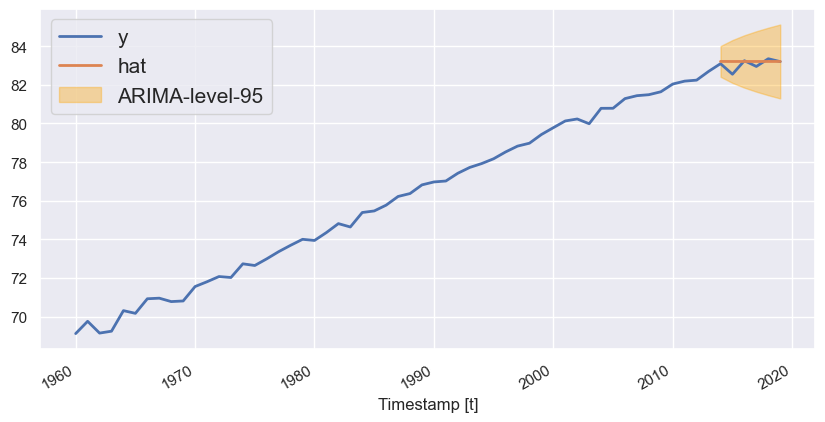

In [36]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
df_plot = pd.concat([df, forecast])
df_plot[['y', 'hat']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['lo-95'], 
                df_plot['hi-95'],
                alpha=.35,
                color='orange',
                label='ARIMA-level-95')
ax.set_title('', fontsize=22)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=12)
ax.legend(prop={'size': 15})
ax.grid(True)

### Model Evaluation
The commonly used accuracy metrics to judge forecasts are:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Correlation between the Actual and the Forecast (corr)

In [37]:
df.reset_index("ds", inplace=True)
Y_train_df = df[df.ds<='2013-01-01'] 
Y_test_df = df[df.ds>'2013-01-01'] 

Y_train_df.shape, Y_test_df.shape

((54, 3), (6, 3))

In [ ]:
from utils import model_evaluation

In [39]:
model_evaluation(Y_test_df["y"], forecast["hat"], "Arima")

Model Evaluation: Arima
MSE is : 0.08948997569112566
MAE is : 0.20368308145509437
RMSE is : 0.29914875177932077
MAPE is : 0.24599653578485167
R2 is : -0.2941030462373293
corr is : 0.3773986084603554



Around 24.43% MAPE implies the model is about 75.57% accurate in predicting the next 6 observations. Now we know how to build an ARIMA model manually.